In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

from pprint import pprint

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston

%matplotlib inline

In [2]:
from sklearn import base

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, average_precision_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve

from sklearn.inspection import permutation_importance

from xgboost.sklearn import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline

### Load the data
Source: https://www.kaggle.com/c/titanic/data

In [3]:
df = pd.read_csv('./data/train.csv')
print (len(df))
df.head()

891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Exploratory data analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Missing values
* Column 'Embarked' has 2 missing values. We will impute them using scikit-learn
* Column 'Age' has 177 missing values. We will impute them using scikit-learn as well
* Column 'Cabin' has 687 missing values. We will create derived features using this column taking into account the missing values

In [5]:
df.isna().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### Target variable

In [7]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

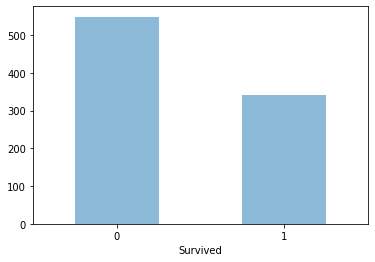

In [8]:
df['Survived'].value_counts().plot.bar(alpha=0.5, rot=0)
plt.xlabel('Survived');

#### Derived features

In [9]:
# CabinType
df['CabinType'] = df['Cabin'].str.extract(r'([A-Za-z])')
df.loc[df['CabinType'].isna(), 'CabinType'] = 'Missing'  

In [10]:
pd.crosstab(df['CabinType'], df['Survived'], margins=True)

Survived,0,1,All
CabinType,,,
A,8,7,15
B,12,35,47
C,24,35,59
D,8,25,33
E,8,24,32
F,5,8,13
G,2,2,4
Missing,481,206,687
T,1,0,1


In [11]:
# Most passengers with known cabin survived and passengers with missing cabin value didn't survive.
# We create a new feature IsCabinMissing to add this signal.

df['IsCabinMissing'] = df['Cabin'].isna()

In [12]:
pd.crosstab(df['IsCabinMissing'], df['Survived'], margins=True)

Survived,0,1,All
IsCabinMissing,,,
False,68,136,204
True,481,206,687
All,549,342,891


In [13]:
# HasMultipleCabins
df['HasMultipleCabins'] = (df['Cabin'].str.count(r'([A-Za-z])') > 1)

In [14]:
pd.crosstab(df['HasMultipleCabins'], df['Survived'], margins=True)

Survived,0,1,All
HasMultipleCabins,,,
False,539,328,867
True,10,14,24
All,549,342,891


In [15]:
pd.crosstab(df['HasMultipleCabins'], df['Survived'], margins=True, normalize='columns')

Survived,0,1,All
HasMultipleCabins,,,
False,0.981785,0.959064,0.973064
True,0.018215,0.040936,0.026936


HasMultipleCabins has very small variance (sqrt(p*(1-p))). So we will not include this feature.  
Compare np.sqrt(0.02*0.08) = 0.04 and np.sqrt(0.5*0.5) = 0.5

In [16]:
# IsNumericTicket
df['IsNumericTicket'] = df['Ticket'].str.isnumeric()

In [17]:
pd.crosstab(df['IsNumericTicket'], df['Survived'], margins=True)

Survived,0,1,All
IsNumericTicket,,,
False,142,88,230
True,407,254,661
All,549,342,891


In [18]:
# NameTitle
df['NameTitle'] = df['Name'].str.extract(r'\, (.*?)\.')  # Extract letters between ',' and '.'

In [19]:
pd.crosstab(df['NameTitle'], df['Survived'], margins=True)

Survived,0,1,All
NameTitle,,,
Capt,1,0,1
Col,1,1,2
Don,1,0,1
Dr,4,3,7
Jonkheer,1,0,1
Lady,0,1,1
Major,1,1,2
Master,17,23,40
Miss,55,127,182


Keep labels Master, Miss, Mr, Mrs. Group all other labels.

In [20]:
df.loc[~df['NameTitle'].isin(('Master', 'Miss', 'Mr', 'Mrs')), 'NameTitle'] = 'Other'

In [21]:
pd.crosstab(df['NameTitle'], df['Survived'], margins=True)

Survived,0,1,All
NameTitle,,,
Master,17,23,40
Miss,55,127,182
Mr,436,81,517
Mrs,26,99,125
Other,15,12,27
All,549,342,891


#### Numerical features

In [22]:
numerical_feats = ['Age', 'Fare']

/home/nkharche/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


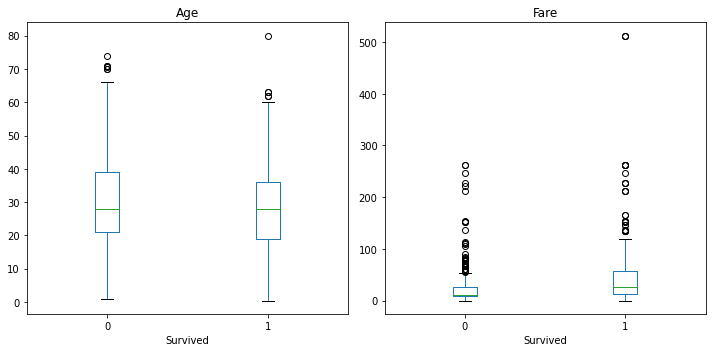

In [23]:
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(10, 5))
df.boxplot(column=numerical_feats, by='Survived',
                 ax=axes, grid=False
)
fig.tight_layout()
fig.suptitle('');

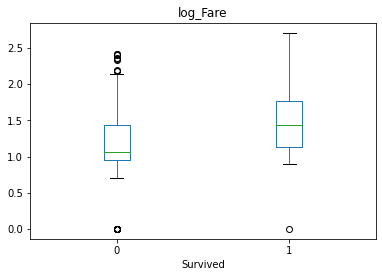

In [24]:
df['log_Fare'] = np.log10(1 + df['Fare'])

df.boxplot(column=['log_Fare'], by='Survived', grid=False)
plt.suptitle('');

#### Categorical features and encoded numerical features

In [25]:
categorical_feats = ['Sex', 'Embarked', 'IsCabinMissing', 'IsNumericTicket', 'NameTitle']

categorical_feats_to_encode_as_ordinal = ['Pclass', 'SibSp', 'Parch', ]

In [26]:
for feat in categorical_feats + categorical_feats_to_encode_as_ordinal:
    #display (df.groupby('Survived')[feat].value_counts().unstack(0))
    display (pd.crosstab(df[feat], df['Survived'], margins=True))

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


Survived,0,1,All
Embarked,,,
C,75,93,168
Q,47,30,77
S,427,217,644
All,549,340,889


Survived,0,1,All
IsCabinMissing,,,
False,68,136,204
True,481,206,687
All,549,342,891


Survived,0,1,All
IsNumericTicket,,,
False,142,88,230
True,407,254,661
All,549,342,891


Survived,0,1,All
NameTitle,,,
Master,17,23,40
Miss,55,127,182
Mr,436,81,517
Mrs,26,99,125
Other,15,12,27
All,549,342,891


Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


Survived,0,1,All
SibSp,,,
0,398,210,608
1,97,112,209
2,15,13,28
3,12,4,16
4,15,3,18
5,5,0,5
8,7,0,7
All,549,342,891


Survived,0,1,All
Parch,,,
0,445,233,678
1,53,65,118
2,40,40,80
3,2,3,5
4,4,0,4
5,4,1,5
6,1,0,1
All,549,342,891


In [27]:
def barplots_of_features_and_target_counts(df, feature_names, target_name, 
                                           normalize=False, plotGrid=None):
    if not plotGrid:
        ncols = 3
        nrows = np.int(np.ceil(len(feature_names)/ncols))
    else:
        nrows, ncols = plotGrid    
    
    sharey = True if normalize==True else False
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10), sharey=sharey)
    axes = axes.reshape(-1, ncols) # Make sure axes is a 2D array  
    
    for k, feat_name in enumerate(feature_names):
        i, j = divmod(k, ncols)
        ax = axes[i][j]
        #(df.groupby(feat_name)[target_name]
        # .value_counts(normalize=normalize).unstack(0).T
        # .plot.bar(rot=45, ax=axes[i][j])
        #)
        (pd.crosstab(df[feat_name], df[target_name], normalize=normalize)
         .plot.bar(rot=45, ax=axes[i][j])
        )        
        
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)  
    
    # Remove emplty subplots
    for k in range(len(feature_names), nrows*ncols):
        fig.delaxes(axes.flatten()[k])  

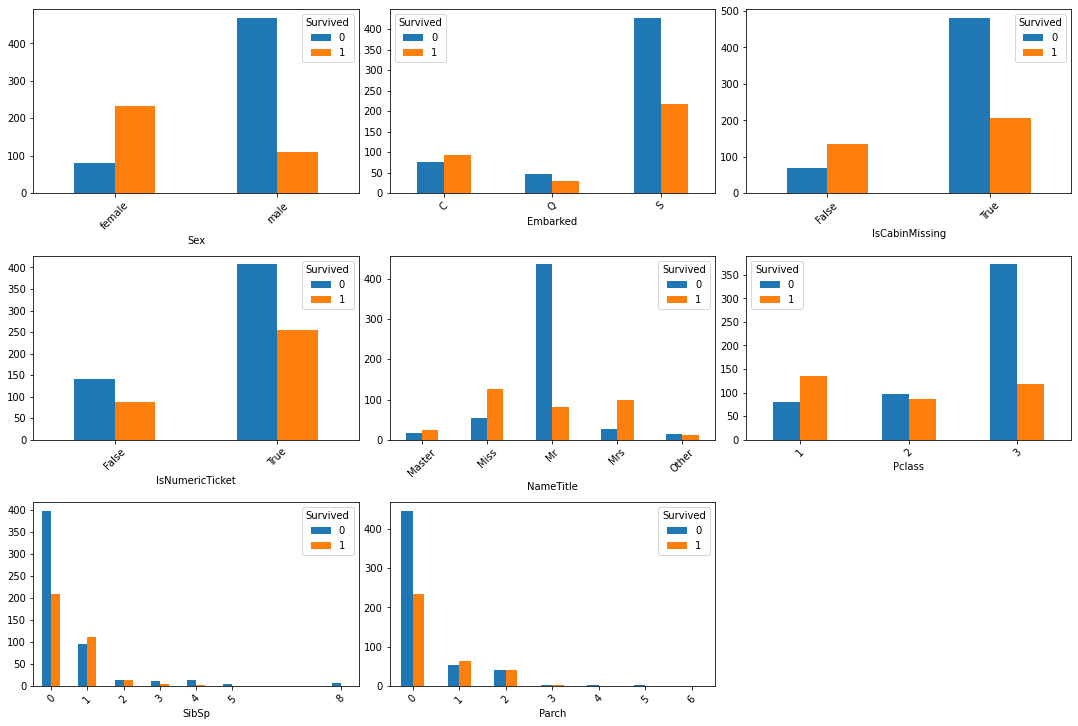

In [28]:
barplots_of_features_and_target_counts(
    df, 
    categorical_feats + categorical_feats_to_encode_as_ordinal, 
    'Survived', 
    normalize=False,
    plotGrid=None
)       

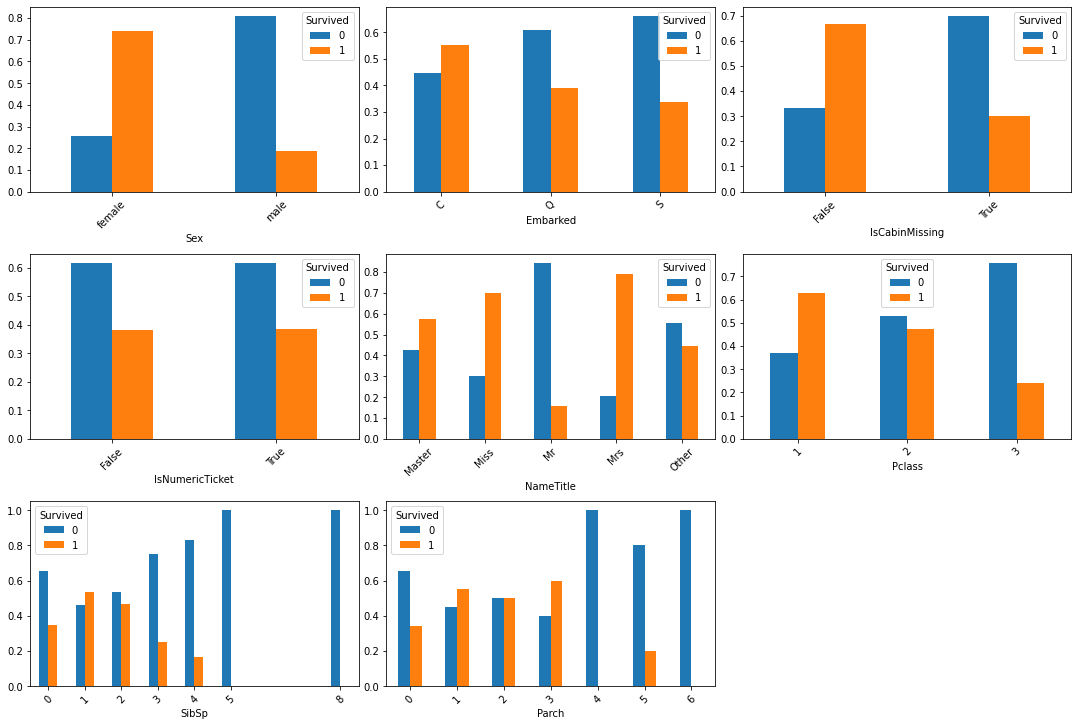

In [29]:
barplots_of_features_and_target_counts(
    df, 
    categorical_feats + categorical_feats_to_encode_as_ordinal, 
    'Survived', 
    normalize='index',
    plotGrid=None
)       

### Feature pipeline

In [30]:
numerical_feats

['Age', 'Fare']

In [31]:
categorical_feats_to_encode_as_ordinal

['Pclass', 'SibSp', 'Parch']

In [32]:
categorical_feats

['Sex', 'Embarked', 'IsCabinMissing', 'IsNumericTicket', 'NameTitle']

In [33]:
class ColumnSelector(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns].values

In [34]:
numerical_feature_union = FeatureUnion([
    ('Age', Pipeline([
        ('column_selector', ColumnSelector(columns=['Age'])),
    ])),
    
    ('Fare', Pipeline([
        ('column_selector', ColumnSelector(columns=['Fare'])),
        ('log1p_transformer', FunctionTransformer(np.log1p))
    ])),
    
    ('Pclass', Pipeline([
        ('column_selector', ColumnSelector(columns=['Pclass'])),
    ])),    
    
    ('SibSp', Pipeline([
        ('column_selector', ColumnSelector(columns=['SibSp'])),
    ])),    
    
    ('Parch', Pipeline([
        ('column_selector', ColumnSelector(columns=['Parch'])),
    ]))
    
])

#numerical_feature_union.fit_transform(df)

In [35]:
categorical_feature_union = FeatureUnion([
    
    ('Sex', Pipeline([
        ('column_selector', ColumnSelector(columns=['Sex'])),
        ('ord_encoder', OrdinalEncoder(categories=[['male', 'female']]))
    ])),
    
    ('Embarked', Pipeline([
        ('column_selector', ColumnSelector(columns=['Embarked'])),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])),
    
    ('IsCabinMissing', ColumnSelector(columns=['IsCabinMissing'])),
    
    ('IsNumericTicket', ColumnSelector(columns=['IsNumericTicket'])),
    
    ('NameTitle', Pipeline([
        ('column_selector', ColumnSelector(columns=['NameTitle'])),
        ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])),
            
])

#categorical_feature_union.fit_transform(df)

In [36]:
numerical_feature_transformer = Pipeline([
    ('numerical_feature_union', numerical_feature_union),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_feature_transformer = Pipeline([
    ('categorical_feature_union', categorical_feature_union),
])

all_feature_transformers = FeatureUnion([
    ('num', numerical_feature_transformer),
    ('cat', categorical_feature_transformer)
])

#numerical_feature_transformer.fit_transform(df)
#categorical_feature_transformer.fit_transform(df)
#all_feature_transformers.fit_transform(df)

### Models

In [37]:
feature_names = (
    numerical_feats + 
    categorical_feats_to_encode_as_ordinal + 
    categorical_feats
)

print (feature_names)

['Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'Sex', 'Embarked', 'IsCabinMissing', 'IsNumericTicket', 'NameTitle']


In [38]:
X = df[categorical_feats + numerical_feats + categorical_feats_to_encode_as_ordinal]
y = df['Survived']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [40]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 10), (712,), (179, 10), (179,))

In [41]:
def plot_roc_curve(clf, X, y, pos_label):
    y_score = clf.predict_proba(X)[:,1]

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y.values, y_score, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, '-', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    
def confusion_matrix_plot(clf, X, y):
    # Plot confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        #("Normalized confusion matrix", 'true')
    ]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(
            clf, X, y,
            cmap=plt.cm.Blues,
            normalize=normalize,
            xticks_rotation=45
        )
        disp.ax_.set_title(title)
    

def get_permutation_importance(est, feature_names, X, y, n_repeats=10):
    # Source: https://scikit-learn.org/stable/modules/permutation_importance.html
    
    r = permutation_importance(est, X, y, n_repeats=n_repeats, random_state=42)    
    df = pd.DataFrame(columns=['feature_name', 'importance_mean', 'importance_std'])
    for i in r.importances_mean.argsort()[::-1]:
        if True: #r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            df = df.append(
                pd.Series([feature_names[i], r.importances_mean[i], r.importances_std[i]], index=df.columns),
                ignore_index=True
            )    
    return df

### Logistic regression

In [42]:
lr_clf = Pipeline([
    ('preprocessor', all_feature_transformers),
    #('lr', LogisticRegression()),
    ('lr', SGDClassifier(loss='log', early_stopping=True, validation_fraction=0.1))
])

param_grid = {
    'lr__penalty' : ['l2'],
    'lr__alpha' : np.logspace(-4, 4, 20)
}

searchCV = GridSearchCV(lr_clf, cv=5, scoring='roc_auc', param_grid=param_grid)
searchCV.fit(X_train, y_train)  

best_lr = searchCV.best_estimator_
print("model score: %.3f" % best_lr.score(X_test, y_test))

best_lr.fit(X_train, y_train)

model score: 0.799


Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('num',
                                                 Pipeline(steps=[('numerical_feature_union',
                                                                  FeatureUnion(transformer_list=[('Age',
                                                                                                  Pipeline(steps=[('column_selector',
                                                                                                                   ColumnSelector(columns=['Age']))])),
                                                                                                 ('Fare',
                                                                                                  Pipeline(steps=[('column_selector',
                                                                                                                   ColumnSelector(columns=['Fare'])),
                                     

In [43]:
print ('Classification report: training data')
print (classification_report(y_train, best_lr.predict(X_train), digits=3))
print ('-----------------------')
print ('Classification report: test data')
print (classification_report(y_test, best_lr.predict(X_test), digits=3))

Classification report: training data
              precision    recall  f1-score   support

           0      0.833     0.901     0.866       444
           1      0.810     0.701     0.752       268

    accuracy                          0.826       712
   macro avg      0.822     0.801     0.809       712
weighted avg      0.825     0.826     0.823       712

-----------------------
Classification report: test data
              precision    recall  f1-score   support

           0      0.820     0.867     0.843       105
           1      0.794     0.730     0.761        74

    accuracy                          0.810       179
   macro avg      0.807     0.798     0.802       179
weighted avg      0.809     0.810     0.809       179



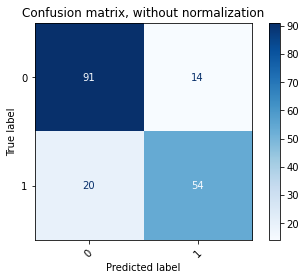

In [44]:
confusion_matrix_plot(best_lr, X_test, y_test)

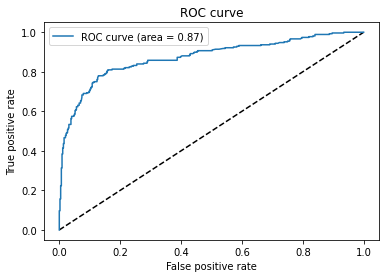

In [45]:
plot_roc_curve(best_lr, X_train, y_train, pos_label=1)

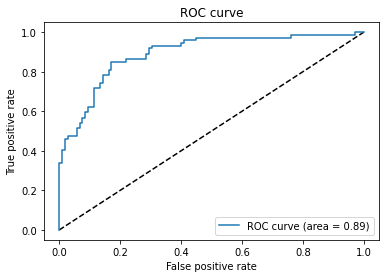

In [46]:
plot_roc_curve(best_lr, X_test, y_test, pos_label=1)

Average precision score: 0.87


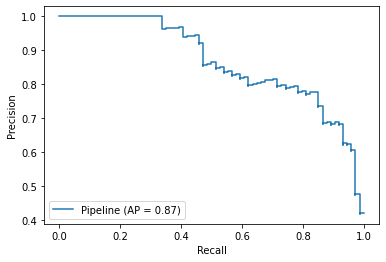

In [47]:
print ('Average precision score: {:.2f}'.format(
    average_precision_score(y_test, best_lr.predict_proba(X_test)[:,1], pos_label=1)
))

plot_precision_recall_curve(best_lr, X_test, y_test);

#### Feature importance in logistic regression model

In [48]:
df_feat_imp = get_permutation_importance(best_lr, feature_names, X_test, y_test, n_repeats=30)

df_feat_imp

,feature_name,importance_mean,importance_std
0,Parch,0.082495,0.019119
1,Sex,0.049534,0.020488
2,Age,0.035196,0.017793
3,IsNumericTicket,0.019739,0.010574
4,Fare,0.014339,0.012127
5,Pclass,0.012104,0.006779
6,NameTitle,0.010428,0.008253
7,IsCabinMissing,0.005773,0.012941
8,Embarked,-0.000372,0.012977
9,SibSp,-0.007449,0.004637


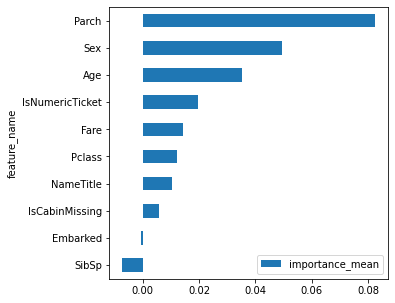

In [49]:
df_feat_imp.sort_values(by=['importance_mean']).plot.barh(x='feature_name', y='importance_mean', figsize=(5, 5));

### XGBoost

In [50]:
xgb_clf = Pipeline([
    ('preprocessor', all_feature_transformers),
    ('xgb', XGBClassifier())
])

param_grid = {
    "xgb__n_estimators": [100, 500],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__max_depth": [5, 10],
    'xgb__colsample_bytree': [0.2, 0.4, 0.8,]
}

searchCV = GridSearchCV(xgb_clf, cv=5, scoring='roc_auc', param_grid=param_grid)
searchCV.fit(X_train, y_train)  

best_xgb = searchCV.best_estimator_
print("model score: %.3f" % best_xgb.score(X_test, y_test))

model score: 0.832


In [51]:
pprint (searchCV.best_params_)

{'xgb__colsample_bytree': 0.4,
 'xgb__learning_rate': 0.01,
 'xgb__max_depth': 10,
 'xgb__n_estimators': 500}


In [52]:
print ('Classification report: training data')
print (classification_report(y_train, best_xgb.predict(X_train), digits=3))
print ('-----------------------')
print ('Classification report: test data')
print (classification_report(y_test, best_xgb.predict(X_test), digits=3))

Classification report: training data
              precision    recall  f1-score   support

           0      0.900     0.971     0.934       444
           1      0.944     0.821     0.878       268

    accuracy                          0.914       712
   macro avg      0.922     0.896     0.906       712
weighted avg      0.917     0.914     0.913       712

-----------------------
Classification report: test data
              precision    recall  f1-score   support

           0      0.838     0.886     0.861       105
           1      0.824     0.757     0.789        74

    accuracy                          0.832       179
   macro avg      0.831     0.821     0.825       179
weighted avg      0.832     0.832     0.831       179



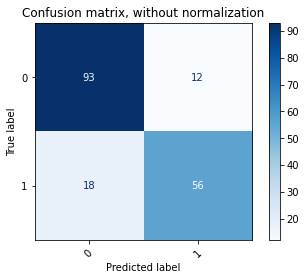

In [53]:
confusion_matrix_plot(best_xgb, X_test, y_test)

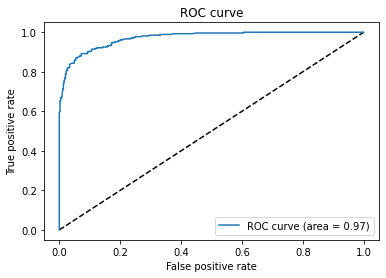

In [54]:
plot_roc_curve(best_xgb, X_train, y_train, pos_label=1)

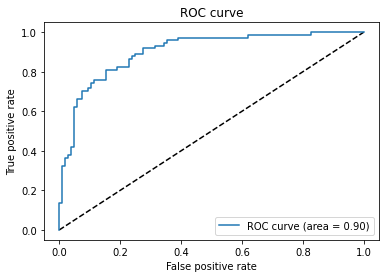

In [55]:
plot_roc_curve(best_xgb, X_test, y_test, pos_label=1)

Average precision score: 0.86


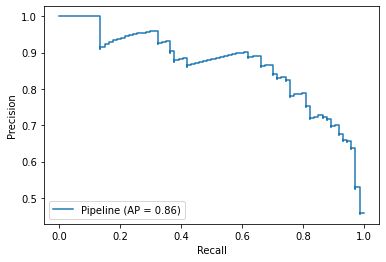

In [56]:
print ('Average precision score: {:.2f}'.format(
    average_precision_score(y_test, best_xgb.predict_proba(X_test)[:,1], pos_label=1)
))

plot_precision_recall_curve(best_xgb, X_test, y_test);

#### Feature importance in XGBoost model

In [57]:
df_feat_imp = get_permutation_importance(best_xgb, feature_names, X_test, y_test, n_repeats=30)
df_feat_imp

,feature_name,importance_mean,importance_std
0,Parch,0.109497,0.022188
1,Fare,0.027561,0.007486
2,Embarked,0.021415,0.015339
3,IsCabinMissing,0.019367,0.011148
4,Age,0.018063,0.017589
5,Pclass,0.013780,0.010274
6,Sex,0.011173,0.010985
7,SibSp,0.007076,0.004063
8,IsNumericTicket,0.004097,0.006908
9,NameTitle,-0.002607,0.004263


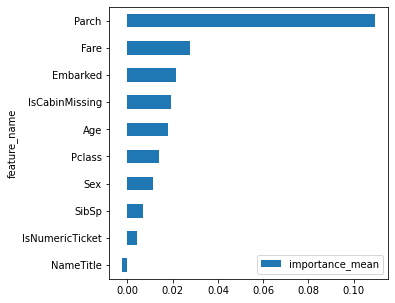

In [58]:
df_feat_imp.sort_values(by=['importance_mean']).plot.barh(x='feature_name', y='importance_mean', figsize=(5, 5));

### XGBoost + SMOTE

In [59]:
xgb_clf = ImblearnPipeline([
    ('preprocessor', all_feature_transformers),
    ('sampling', SMOTE(sampling_strategy=1.0, random_state=42)),
    ('xgb', XGBClassifier())
])

param_grid = {
    "xgb__n_estimators": [100, 500],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__max_depth": [5, 10],
    'xgb__colsample_bytree': [0.2, 0.4, 0.8,]
}

searchCV = GridSearchCV(xgb_clf, cv=5, scoring='roc_auc', param_grid=param_grid)
searchCV.fit(X_train, y_train)  

best_xgb = searchCV.best_estimator_
print("model score: %.3f" % best_xgb.score(X_test, y_test))

model score: 0.816


In [60]:
pprint (searchCV.best_params_)

{'xgb__colsample_bytree': 0.4,
 'xgb__learning_rate': 0.01,
 'xgb__max_depth': 10,
 'xgb__n_estimators': 100}


In [61]:
print ('Classification report: training data')
print (classification_report(y_train, best_xgb.predict(X_train), digits=3))
print ('-----------------------')
print ('Classification report: test data')
print (classification_report(y_test, best_xgb.predict(X_test), digits=3))

Classification report: training data
              precision    recall  f1-score   support

           0      0.893     0.926     0.909       444
           1      0.869     0.817     0.842       268

    accuracy                          0.885       712
   macro avg      0.881     0.871     0.876       712
weighted avg      0.884     0.885     0.884       712

-----------------------
Classification report: test data
              precision    recall  f1-score   support

           0      0.840     0.848     0.844       105
           1      0.781     0.770     0.776        74

    accuracy                          0.816       179
   macro avg      0.810     0.809     0.810       179
weighted avg      0.815     0.816     0.815       179



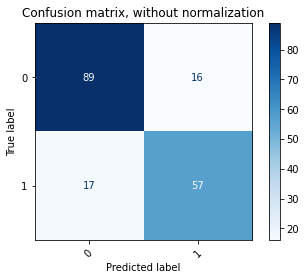

In [62]:
confusion_matrix_plot(best_xgb, X_test, y_test)

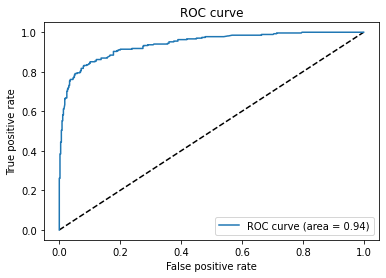

In [63]:
plot_roc_curve(best_xgb, X_train, y_train, pos_label=1)

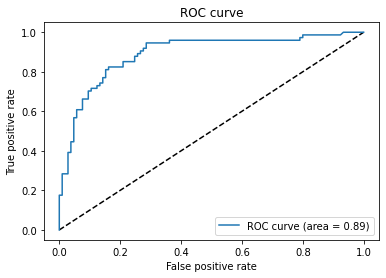

In [64]:
plot_roc_curve(best_xgb, X_test, y_test, pos_label=1)

Average precision score: 0.86


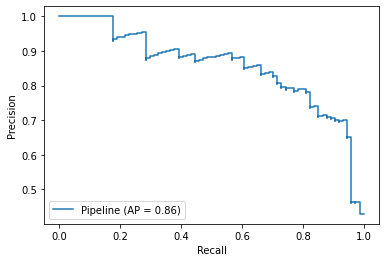

In [65]:
print ('Average precision score: {:.2f}'.format(
    average_precision_score(y_test, best_xgb.predict_proba(X_test)[:,1], pos_label=1)
))

plot_precision_recall_curve(best_xgb, X_test, y_test);

#### Feature importance in XGBoost + SMOTE model

In [66]:
df_feat_imp = get_permutation_importance(best_xgb, feature_names, X_test, y_test, n_repeats=30)
df_feat_imp

,feature_name,importance_mean,importance_std
0,Parch,0.115084,0.025051
1,IsCabinMissing,0.009870,0.009749
2,Embarked,0.008752,0.010955
3,Sex,0.008380,0.009541
4,Pclass,0.005214,0.007486
5,SibSp,0.003911,0.004596
6,IsNumericTicket,0.001304,0.004930
7,Fare,-0.000559,0.005651
8,NameTitle,-0.000745,0.003138
9,Age,-0.002793,0.016240


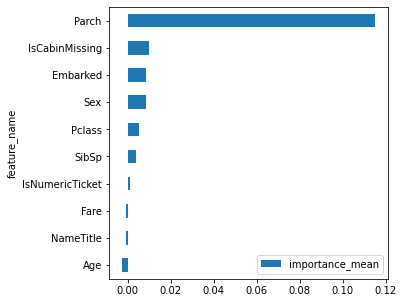

In [67]:
df_feat_imp.sort_values(by=['importance_mean']).plot.barh(x='feature_name', y='importance_mean', figsize=(5, 5));